In [66]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

inf = 1e+6

# Construct potentials

$$c_{ij} = \max\limits_{k \in \{ 1, \dots, K\}} | I_i(k) - I_j(k) |$$

$$d(x_i, x_j) = |x_i \neq x_j|$$

In [146]:
tmp = plt.imread('data/syntetic/1.jpg')
K = 3
n, m = tmp.shape[:2]
inputs = np.zeros((K, n, m, 3))
masks = np.zeros((K, n, m))
for k in xrange(K):
    inputs[k] = plt.imread('data/syntetic/' + str(k+1) + '.jpg')
    cur_mask = plt.imread('data/syntetic/' + str(k+1) + 'mask.jpg')
    masks[k] = np.all(cur_mask > 230, axis=2)    

In [147]:
N_vert = n * m
M_edg = 2 * (n-1) * (m-1) + (n-1) + (m-1)

In [153]:
c_pairwise = np.zeros((M_edg, 3))
phi_unaries = np.zeros((N_vert, K))
i_vert = 0
j_edge = 0
for ih in xrange(n):
    for iw in xrange(m):
        phi_unaries[i_vert] = inf * (1 - masks[:, ih, iw])
        if ih + 1 < n:
            c_pairwise[j_edge] = i_vert, i_vert + m, np.max(np.linalg.norm(inputs[:, ih, iw] - inputs[:, ih+1, iw], 
                                                                           axis=1))
            j_edge += 1
        if iw + 1 < m:
            c_pairwise[j_edge] = i_vert, i_vert + 1, np.max(np.linalg.norm(inputs[:, ih, iw] - inputs[:, ih, iw+1], 
                                                                           axis=1))
            j_edge += 1
        
        i_vert += 1

# $\alpha$-expansion

$\alpha$-expansion is an iterative process, where on each step some label $\alpha$ is chosen and some variables $x_i$ can change their value to $alpha$.


In [154]:
# source, sink
terminal_weights = np.array([[16,0],[13,0],[0,20],[0,4]], dtype=float)

# From, To, Capacity, Rev_Capacity
edge_weights = np.array([[0,1,10,4], [0,2,12,0], [1,2,0,9], [1,3,14,0], [2,3,0,7]], dtype=float)

(cut, labels) = graph_cut(terminal_weights, edge_weights)
print (cut, labels)

(23.0, array([0, 0, 1, 0], dtype=int32))


In [155]:
from graph_cut import graph_cut

def d(x_i, x_j):
    return int(x_i != x_j)

def alpha_expansion(phi_unary, c_pairwise, d, max_iter=100, tol=1e-3):
    '''
    Parameters:
        phi_unary -- matrix of unary potentials (N_vert x K)
        c_pairwise -- matrix of weights on the lattice (M_edg x 3),
            where each of 3 numbers are (from, to, c_{ij})
        d -- metric function        
    '''    
    # N_vert -- number of vertices
    # K -- number of classes
    N_vert, K = phi_unary.shape
    # M_edg -- number of edges
    M_edg = c_pairwise.shape[0]
    
    X = np.zeros(N_vert, dtype='int')
    
    E_old = np.inf
    alpha = 0
    for i_iter in xrange(max_iter):
        # randomly select alpha
        #alpha = np.random.randint(K)
        alpha = (alpha + 1) % K
        
        ################ Construct the graph #######################
        terminal_weights = np.zeros((N_vert, 2))
        edge_weights = np.zeros((M_edg, 4))
        
        terminal_weights[:, 0] = phi_unary[np.arange(N_vert), X] # y_i = 0 (X_i^{new} != \alpha)
        terminal_weights[X == alpha, 0] = inf # y_i cannot be zero where X_i^{old} = \alpha
        terminal_weights[:, 1] = phi_unary[:, alpha] # y_i = 1 (X_i^{new} = alpha)
        
        for j in xrange(M_edg):
            from_, to_, weight = c_pairwise[j]
            from_, to_ = int(from_), int(to_)
            phi_a = weight * d(X[from_], X[to_])
            phi_b = weight * d(X[from_], alpha)
            phi_c = weight * d(alpha, X[to_])
            phi_d = weight * d(alpha, alpha)
            
            phi_b_hat = (phi_b - phi_a + phi_c - phi_d)/2
            edge_weights[j] = (from_, to_, phi_b_hat, phi_b_hat)
            terminal_weights[from_][0] += phi_a
            terminal_weights[from_][1] += phi_d + (phi_c - phi_d - phi_b + phi_a)/2
            terminal_weights[to_][1] += (phi_b - phi_a - phi_c + phi_d)/2
        
        ################ Run graph cut #############################
        E, labels = graph_cut(terminal_weights, edge_weights)
        X[labels == 0] = alpha
        
        ################ Compute energy ############################
        if E_old - E < tol: break
        else: E_old = E
    
    return X

In [156]:
X = alpha_expansion(phi_unaries, c_pairwise, d)

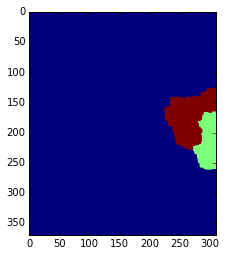

In [157]:
plt.imshow(X.reshape(n, m))

In [158]:
result = np.zeros((n, m, 3))
X = X.reshape(n, m)
for k in xrange(K):
    result += inputs[k] * (X == k)[:, :, None]

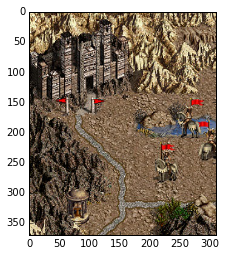

In [159]:
plt.imshow(result.astype('uint8'))

# $\alpha \beta$-swap 